In [190]:
import scipy.integrate as integrate
import scipy.sparse as sparse
import scipy.linalg

import dataclasses
import sys
import numpy as np
np.random.seed(101101)
from tqdm import tqdm
import matplotlib.animation as animation
sys.path.insert(0,'..')

from src.matrices import get_J_matrix

import matplotlib.pyplot as plt
from IPython.display import Video

<h1>02-Use matrices in Diff Eq</h1>
Now we are going to take the matrices for J and H generated previously, and use them as update values to a differential equation. Parameters pulled from last notebook for simulation here.

In [140]:
parameters = [{'u'    :0.5
              ,'w'    :0.0
              ,'alpha':1.0
              ,'beta' :0.0
              ,'gamma':0.0}
              
             ,{'u'    :0.0
              ,'w'    :0.0
              ,'alpha':1.0
              ,'beta' :1.0
              ,'gamma':1.0}
              
             ,{'u'    :0.5
              ,'w'    :0.0
              ,'alpha':1.0
              ,'beta' :1.0
              ,'gamma':1.0}
              
             ,{'u'    :0.5
              ,'w'    :0.5
              ,'alpha':1.0
              ,'beta' :1.0
              ,'gamma':1.0}]

N = 200
u, w, alpha, beta, gamma = parameters[2].values()
matrix = get_J_matrix(N,**parameters[2])

<h2>Eigenvales and Eigenvectors</h2>
Looking at the greatest eigenvalues and vectors of the matrix in our differential equation will give us an understanding the stable states of the neural system

In [141]:
lambs, vecs = scipy.linalg.eig(np.array(matrix))

In [142]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [153]:
from dataclasses import dataclass

<h2>Define Differential Equation</h2>
Here we define the differential equation as defined in Tanaka et al. equation (8)

In [171]:
@dataclass
class NeuronDiffEq:
    matrix: np.matrix
    tau: np.double
    N: int
    
    def activation(self,x):
        '''
            Activation function on neurons that take sum of inputs
        '''
        out = np.zeros(x.shape)
        out[(x + 1) < 0]  = 0.0
        out[(x + 1) >= 0] = x[(x + 1) >= 0] + 1
        return out
    
    def external(self,t):
        '''
            External input to each neuron at time, t
        '''
        
        return 0.0
    
    def __call__(self,r,t):
        
        interactions = np.array(self.matrix @ r).squeeze()
    
        out = (-r + self.activation(interactions + self.external(t)).squeeze())/self.tau
        return out

Now we can use our class format to alternate types of external input

In [243]:
@dataclass
class NoisyNeuron(NeuronDiffEq):
    mu: np.double
    sigma: np.double
    
    def external(self,t):
        
        out = np.random.normal(self.mu,self.sigma,self.N)
#         print(out[:10])
        return out

@dataclass
class ConstantInput(NeuronDiffEq):
    constant: np.double
    sites: slice
    
    def external(self,t):
        
        out = np.zeros(self.N)
        out[self.sites] = self.constant
        return out

<h2>Simulation Time</h2>
Now we are going to simulate the neurons as connected by the above matrix.

In [249]:
tau = 5
tspace = range(100)
r0 = np.zeros(N)
# r0[:N//4] = 1.0
in_array = np.zeros((len(tspace),*r0.shape))

mu = 0.0
sigma = 10.0
constant = 3.0
sites = slice(0,N//3)
# neurons = NoisyNeuron(matrix,tau,N,mu,sigma)
neurons = ConstantInput(matrix,tau,N,constant,sites)
results = integrate.odeint(neurons,r0,tspace)

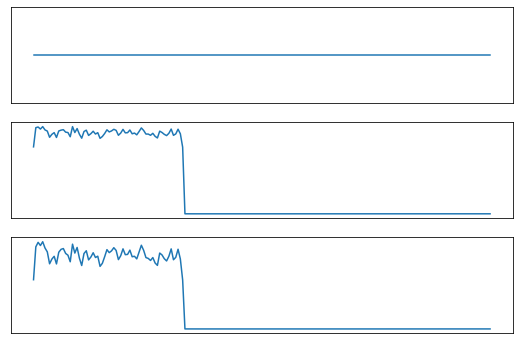

In [250]:
n_imgs = 3
strt_img = 0

fig, axs = plt.subplots(n_imgs,figsize=(3*n_imgs,6))
# metrics = np.zeros((len(kernels),*image.shape))
for index,img_i in enumerate(range(strt_img,n_imgs+strt_img)):

    axs[index].plot(results[img_i,...])
    axs[index].set_xticks([])
    axs[index].set_yticks([])
        
plt.show()

Reorder of eigenvectors by largest values. And selecting some to plot.

In [246]:
eig_n = 10
ordered_inds = np.argsort(lambs.real)
vecs_sp = vecs[:,ordered_inds[:eig_n]]

In [247]:
vecs_sp.shape

(200, 10)

script to write a movie of the neural state evolving over time.

102it [00:07, 14.53it/s]                         


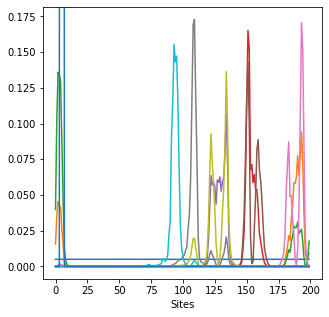

In [248]:
fig, ax = plt.subplots(figsize=(5, 5))

for iii in range(eig_n):
    ax.plot(np.abs(vecs_sp[:,iii])**2)

line, = ax.plot(results[0,...])
# ax.axis('equal')
ax.set_xlabel('Sites')


orders = np.arange(0,len(tspace),dtype=int)
with tqdm(total=len(tspace)) as pbar:
        
    def next_image(index):
        
        line.set_ydata(results[index,...])
#         ax.set_title("{}".format(tim_stack[index]))
        pbar.update(1)
        
        return line,
            
    ani = animation.FuncAnimation(
        fig,
        next_image,
        frames=orders,
        interval=200,
        repeat=False,
        repeat_delay=100,
        blit=True
    )
#     plt.show()
    filename = "diffeqJ_u{}_w{}_a{}_b{}_g{}.mp4".format(u,w,alpha,beta,gamma)
    ani.save(filename)

In [235]:
Video(filename)